<a href="https://colab.research.google.com/github/JaperTai77/Tensorflow_DL/blob/main/CV_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classification

### Import Package and Data

In [1]:
import cv2
import numpy as np
import os
import zipfile
from google.colab.patches import cv2_imshow
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = '/content/homer_bart_1.zip'
data_zip = zipfile.ZipFile(file = path, mode = 'r')
data_zip.extractall('./')
data_zip.close()

In [3]:
files = [os.path.join('/content/homer_bart_1', f) for f in sorted(os.listdir('/content/homer_bart_1'))]

(557, 476, 3)


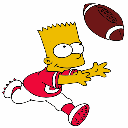

(375, 300, 3)


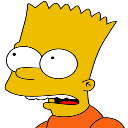

(505, 280, 3)


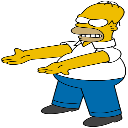

(597, 336, 3)


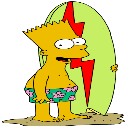

In [4]:
for i in range(4):
  s = int(np.random.uniform(0,len(files),1))
  im = files[s]
  im = cv2.imread(im)
  print(im.shape)
  im = cv2.resize(im, (128, 128))
  cv2_imshow(im)

## Feature Extractor

In [6]:
export = 'mouth,pants,shoes,tshirt,shorts,sneakers,class\n'
features = []

RGB color in CV2: [B,G,R]

In [7]:
for image_path in files:
  try:
    im = cv2.imread(image_path)
    (H,W) = im.shape[:2]
  except:
    continue

  image = im.copy()
  image_features = []
  mouth = pants = shoes = 0
  tshirt = shorts = sneakers = 0
  image_name = os.path.basename(os.path.normpath(image_path))

  if image_name.startswith('b'):
    class_name = 0
  else:
    class_name = 1
  
  # extract color channels
  for height in range(0,H):
    for width in range(0,W):
      blue = image.item(height, width,0)
      green = image.item(height, width, 1)
      red = image.item(height, width, 2)
      
      # Homer - brown mouth
      if (blue >= 95 and blue <= 140 and green >= 160 and green <= 185 and red >= 175 and red <= 200):
        image[height, width] = [0, 255, 255] # convert brown to yellow
        mouth += 1

      # Homer - blue pants
      if (blue >= 150 and blue <= 180 and green >= 98 and green <= 120 and red >= 0 and red <= 90):
        image[height, width] = [0, 255, 255]
        pants += 1

      # Homer - gray shoes
      if height > (H / 2):
        if (blue >= 25 and blue <= 45 and green >= 25 and green <= 45 and red >= 25 and red <= 45):
          image[height, width] = [0, 255, 255]
          shoes += 1

      # Bart - orange t-shirt
      if (blue >= 11 and blue <= 22 and green >= 85 and green <= 105 and red >= 240 and red <= 255):
        image[height, width] = [0, 255, 128]
        tshirt += 1

      # Bart - blue shorts
      if (blue >= 125 and blue <= 170 and green >= 0 and green <= 12 and red >= 0 and red <= 20):
        image[height, width] = [0, 255, 128]
        shorts += 1

      # Bart - blue sneakers
      if height > (H / 2):
        if (blue >= 125 and blue <= 170 and green >= 0 and green <= 12 and red >= 0 and red <= 20):
          image[height, width] = [0, 255, 128]
          sneakers += 1
          
  mouth = round((mouth / (H*W))*100, 9)
  pants = round((pants / (H * W)) * 100, 9)
  shoes = round((shoes / (H * W)) * 100, 9)
  tshirt = round((tshirt / (H * W)) * 100, 9)
  shorts = round((shorts / (H * W)) * 100, 9)
  sneakers = round((sneakers / (H * W)) * 100, 9)

  image_features.append(mouth)
  image_features.append(pants)
  image_features.append(shoes)
  image_features.append(tshirt)
  image_features.append(shorts)
  image_features.append(sneakers)
  image_features.append(class_name)
  features.append(image_features)

  f = (",".join([str(item) for item in image_features]))
  export += f + '\n'

In [ ]:
'''image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 2)
ax[0].axis('off')
ax[0].imshow(original_image)
ax[1].axis('off')
ax[1].imshow(image)
plt.show()'''

In [12]:
with open('features.csv', 'w') as file:
  for l in export:
    file.write(l)
file.closed

df = pd.read_csv('features.csv')
df.head()

,mouth,pants,shoes,tshirt,shorts,sneakers,class
0,0.0,0.000000,0.114799,6.886102,3.495204,3.495204,0
1,0.0,0.000000,0.110078,5.004901,3.183889,3.183889,0
2,0.0,0.000000,0.182519,5.264620,5.029683,5.029683,0
3,0.0,0.480168,0.080028,0.000000,0.000000,0.000000,0
4,0.0,0.000000,0.029708,8.978929,3.459119,3.459119,0


## Train Test Split

In [13]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(df.iloc[:,:6].values,
                                             df.iloc[:,6].values,
                                             test_size = 0.2)
Xtrain.shape, Xtest.shape

((215, 6), (54, 6))

In [19]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(4,input_shape = (6,),activation = 'relu'))
model.add(tf.keras.layers.Dense(4,activation = 'relu'))
model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])
history = model.fit(Xtrain, ytrain,epochs = 50, batch_size = 128)

Epoch 1/50
2/2 [==============================] - 0s 6ms/step - loss: 0.6839 - accuracy: 0.4140
Epoch 2/50
2/2 [==============================] - 0s 5ms/step - loss: 0.6800 - accuracy: 0.4326
Epoch 3/50
2/2 [==============================] - 0s 7ms/step - loss: 0.6759 - accuracy: 0.4465
Epoch 4/50
2/2 [==============================] - 0s 4ms/step - loss: 0.6720 - accuracy: 0.4558
Epoch 5/50
2/2 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.4512
Epoch 6/50
2/2 [==============================] - 0s 8ms/step - loss: 0.6644 - accuracy: 0.4512
Epoch 7/50
2/2 [==============================] - 0s 10ms/step - loss: 0.6606 - accuracy: 0.4651
Epoch 8/50
2/2 [==============================] - 0s 5ms/step - loss: 0.6568 - accuracy: 0.4791
Epoch 9/50
2/2 [==============================] - 0s 5ms/step - loss: 0.6530 - accuracy: 0.4977
Epoch 10/50
2/2 [==============================] - 0s 8ms/step - loss: 0.6492 - accuracy: 0.5442
Epoch 11/50
2/2 [=====================

## Evaluation

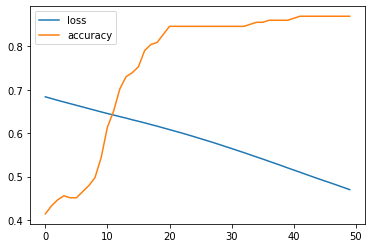

In [21]:
pd.DataFrame(history.history).plot()

In [23]:
pred = model.predict(Xtest)
pred = np.round(pred)

In [28]:
model.evaluate(Xtest,ytest)

2/2 [==============================] - 0s 6ms/step - loss: 0.4628 - accuracy: 0.8704


[0.4628491699695587, 0.8703703880310059]

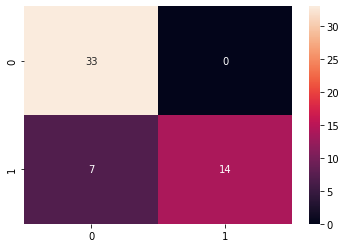

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, pred)
sns.heatmap(cm, annot=True);

## Save model

In [29]:
model_json = model.to_json()
with open('homer_bart_classifier.json','w') as json_file:
  json_file.write(model_json)

In [31]:
with open('homer_bart_classifier.json','r') as json_file:
  json_saved_model = json_file.read()
homer_bart_model = tf.keras.models.model_from_json(json_saved_model)

In [32]:
homer_bart_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 4)                 28        
                                                                 
 dense_14 (Dense)            (None, 4)                 20        
                                                                 
 dense_15 (Dense)            (None, 1)                 5         
                                                                 
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________
